<a href="https://colab.research.google.com/github/Haripriya-2424/AttentionUnet-brainseg/blob/main/Brain_Tumor_Segmentation_with_Attention_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os

root_dir = "/content/drive/MyDrive/BraintumorSegmentation"
image_dir = os.path.join(root_dir, "Dataset/images")
mask_dir = os.path.join(root_dir, "Dataset/masks")


Mounted at /content/drive


In [2]:
!pip install torch torchvision matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Model

In [3]:
import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(AttentionUNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder1 = ConvBlock(in_channels, 64)
        self.encoder2 = ConvBlock(64, 128)
        self.encoder3 = ConvBlock(128, 256)
        self.encoder4 = ConvBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.att4 = AttentionBlock(512, 512, 256)
        self.decoder4 = ConvBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.decoder3 = ConvBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.decoder2 = ConvBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att1 = AttentionBlock(64, 64, 32)
        self.decoder1 = ConvBlock(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.maxpool(e1))
        e3 = self.encoder3(self.maxpool(e2))
        e4 = self.encoder4(self.maxpool(e3))

        b = self.bottleneck(self.maxpool(e4))

        d4 = self.upconv4(b)
        e4 = self.att4(d4, e4)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, e3)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, e2)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, e1)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.decoder1(d1)

        return self.final_conv(d1)


Loading the Data

In [4]:
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image_path = os.path.join(self.image_dir, img_name)

    # Remove any parts like " (1)" from filename before "_mask"
        base_name = img_name.split(".tif")[0].split(" (")[0]
        mask_name = base_name + "_mask.tif"
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        mask = torch.tensor(np.array(mask)).unsqueeze(0).float() / 255.0

        return image, mask

def get_loader(image_dir, mask_dir, batch_size):
    dataset = BrainTumorDataset(image_dir, mask_dir)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


Training the Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Started...


Epoch [10/10]: 100%|██████████| 985/985 [04:53<00:00,  3.35it/s, loss=0.000277]


Model saved to: /content/drive/MyDrive/BraintumorSegmentation/attention_unet.pth


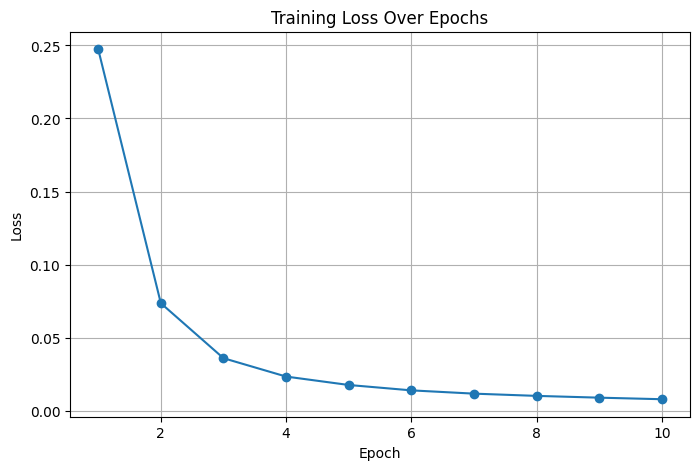

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Paths
image_dir = "/content/drive/MyDrive/BraintumorSegmentation/Dataset/images"
mask_dir = "/content/drive/MyDrive/BraintumorSegmentation/Dataset/masks"
save_model_path = "/content/drive/MyDrive/BraintumorSegmentation/attention_unet.pth"

# Hyperparameters
batch_size = 4
learning_rate = 1e-4
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loader
train_loader = get_loader(image_dir, mask_dir, batch_size)

# Initializing the model, loss, optimizer
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

# Training loop
print("Training Started...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")

    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

# Saving the model to the path
torch.save(model.state_dict(), save_model_path)
print(f"Model saved to: {save_model_path}")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Visualisation of tumor segmentation

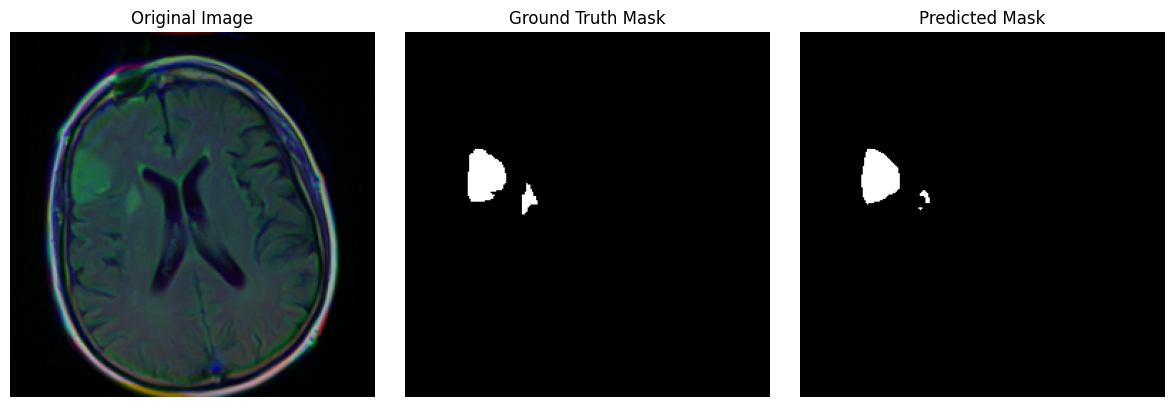

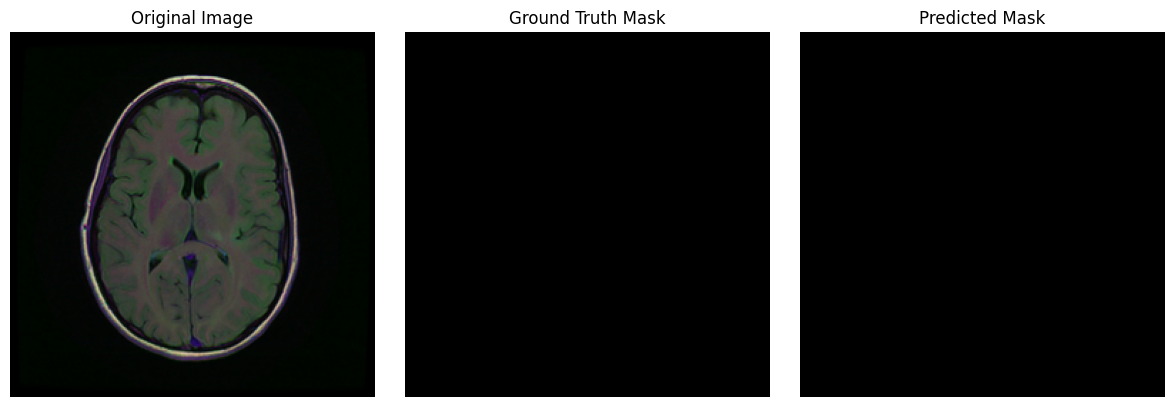

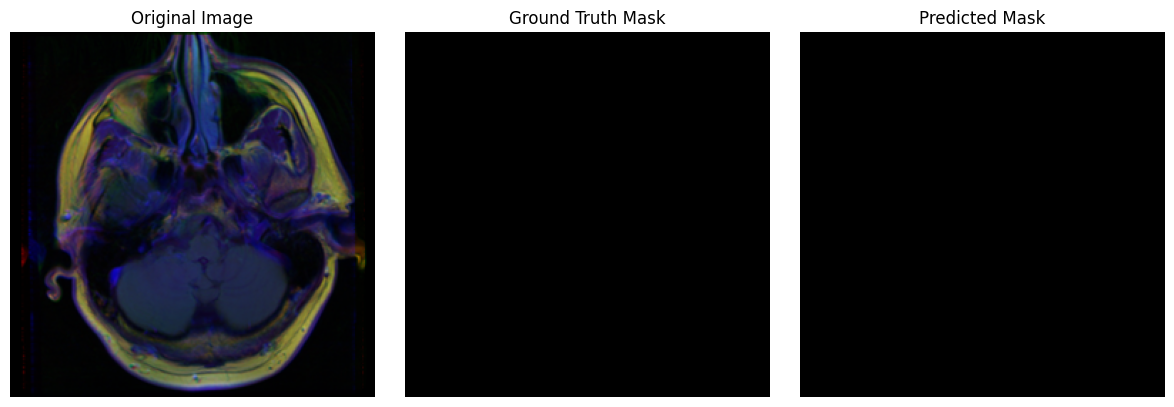


--- Evaluation Metrics ---
Average BCE Loss: 0.0029
Average Dice Coefficient: 0.9655
Average IoU: 0.9374
Average Accuracy: 0.9991


In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import os

# Define the metrics
def dice_coeff(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_coeff(pred, target, smooth=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def binary_accuracy(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)
    correct = (pred == target).sum()
    return correct.item() / len(target)

# Paths
image_dir = "/content/drive/MyDrive/BraintumorSegmentation/Dataset/images"
mask_dir = "/content/drive/MyDrive/BraintumorSegmentation/Dataset/masks"
model_path = "/content/drive/MyDrive/BraintumorSegmentation/attention_unet.pth"

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load data
dataset = BrainTumorDataset(image_dir=image_dir, mask_dir=mask_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Visualize function
def visualize_predictions(num_samples=3):
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_acc = 0
    loss_fn = torch.nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for i, (image, mask) in enumerate(dataloader):
            if i >= num_samples:
                break

            image = image.to(device)
            mask = mask.to(device)

            output = model(image)
            loss = loss_fn(output, mask)
            total_loss += loss.item()

            pred_mask = torch.sigmoid(output).cpu().squeeze().numpy()
            pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
            gt_mask = mask.cpu().squeeze().numpy().astype(np.uint8)

            dice = dice_coeff(torch.tensor(pred_mask_bin), torch.tensor(gt_mask))
            iou = iou_coeff(torch.tensor(pred_mask_bin), torch.tensor(gt_mask))
            acc = binary_accuracy(torch.tensor(pred_mask_bin), torch.tensor(gt_mask))

            total_dice += dice
            total_iou += iou
            total_acc += acc

            img_np = image.cpu().squeeze().permute(1, 2, 0).numpy()

            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(img_np)
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth Mask")
            plt.imshow(gt_mask, cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask_bin, cmap="gray")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

    print(f"\n--- Evaluation Metrics ---")
    print(f"Average BCE Loss: {total_loss / num_samples:.4f}")
    print(f"Average Dice Coefficient: {total_dice / num_samples:.4f}")
    print(f"Average IoU: {total_iou / num_samples:.4f}")
    print(f"Average Accuracy: {total_acc / num_samples:.4f}")


visualize_predictions(num_samples=3)
